In [60]:
## This notebook allows the user to find the extinction ratio of a Laguerre-Gaussian beam, given the image and a selected pixel radius esimate.
## It is better to give a reasonable overestimated radius size to avoid clipping the profile.
## This method uses two orthogonal axes rotated around from the centre of the Laguerre-Gaussian to use true image pixel intensities
## Abrar Shafin, November 2025

import numpy as np
from numpy import sqrt, exp, sin, cos
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage.measure import profile_line
from matplotlib import gridspec
from scipy import stats

#%% [USER INPUTS]

radius = 80
N_deg = 360
filename = '0.157uW.bmp'

In [61]:
#%% [OBTAIN IMAGE DATA & EXTINCTION RATIO]

global FLIR_s, title_fontsize, axis_fontsize
FLIR_s = 6.9e-3      #mm/pix   
title_fontsize, axis_fontsize = 26, 16

image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

w, h = np.arange(image.shape[1]), np.arange(image.shape[0])
w, h = np.meshgrid(w,h)


#%% [DEFINE FUNCTIONS TO DISPLAY IMAGE & CURVEFIT WITH RAVELLED EQUIVALENT]
def LG(x, y, A, x0, y0, w0):

    r = sqrt((x - x0)**2 + (y - y0)**2)
    LG = A*(2*r**2)/(w0**2)*exp(-(r**2)/w0**2)    
    return LG

def LG_ravelled(t, *p):
    x, y = t[0], t[1]
    return LG(x, y, *p).ravel()


#%% [ORGANISE VALUES FOR CURVEFITTING]

t = np.array([w,h])

guess = [1, image.shape[1]//2, image.shape[0]//2, radius]   # [amplitude, x0, y0, waist], (x0,y0) = centered in middle of image

# find the parameters using curve_fit(f(y,p), x, y_data, p0 = initial guess)
p, cov = curve_fit(LG_ravelled, t, image.ravel(), p0 = guess)

# with this fixed, now able to get (x,y) centering coordinates from this method. THis would be the new centering method, to employ the axes in these (x0,y0)
# find the profiles along the radius using x(\theta) = x0 + rcos(\theta) and vice versa for y(\theta)

x0, y0 = int(p[1]), int(p[2])
image = image[y0 - radius:y0 + radius, x0 - radius:x0 + radius]


#%% [REDEFINE IMAGE AXES & IMAGE SHAPE TO OBTAIN INTENSITY PROFILES ALONG DEGREES]

w,h = image.shape[1], image.shape[0]    # working in 1D now
x,y = np.arange(w), np.arange(h)

print('Cropped Image Parameters:')
print(f'Width, Height= {w,h} pixels')
print(f'Radius = {radius} pixels')

degrees = np.linspace(0,np.pi/2,N_deg)  # only need to rotate axis 90 degrees for entire profile capture
D = 2*radius

H_degrees = np.zeros((N_deg, D))
V_degrees = np.zeros((N_deg, D))

for n, deg in enumerate(degrees):

    h_coords = ([h//2 - radius*sin(deg), w//2 - radius*cos(deg)] , [h//2 + radius*sin(deg), w//2 + radius*cos(deg)])
    v_coords = ([h//2 - radius*cos(deg) , w//2 + radius*sin(deg)] , [h//2 + radius*cos(deg), w//2 - radius*sin(deg)])

    #%% {REASONING}
    # Note that to rotate a line about a point is given by x = x0 +- radius*cos(theta), y = y0 +- radius*sin(theta)
    # To ensure the axes stay orthogonal to each other, the derivatives are taken and done so for the vertical line

    profile_h = profile_line(image,h_coords[0],h_coords[1], mode = 'constant')  # let the values outside be redundant data which can be cut off
    profile_v = profile_line(image,v_coords[0],v_coords[1], mode = 'constant')
    # save into a 2D matrix, given the pixels \times degree dimensions

    H_degrees[n,:] = profile_h[:D]
    V_degrees[n,:] = profile_v[:D]

print(f'Horizontal Intensities Matrix shape = {H_degrees.shape}')


#%% [ORGANIZE THE PROFILES OBTAINED AROUND 360 DEGREES INTO ONE VECTOR]

# since for 90 degrees, the profiles of horizontal and verticles were obtained, each degree giving two peaks
# we want to characterize each peak to their respective degrees
# i.e. H_degrees[0,:] = for no image rotation, obtains two peaks at 0 degrees and 180 degrees 
# so create an array such that the collection spans to 360 degrees, the full set

# profiles_360 = np.concatenate( (np.flip(V_degrees[:,:V_degrees.shape[1]//2], axis = 1),   # first quadrant
#                         np.flip(H_degrees[:,:H_degrees.shape[1]//2], axis = 1),           # second quadrant
#                         V_degrees[:,V_degrees.shape[1]//2:],                               # third quadrant
#                         H_degrees[:,H_degrees.shape[1]//2:]), axis = 0)                   # fourth quadrant

profiles_360 = np.concatenate( ( 
    
    np.flip(V_degrees[:,:V_degrees.shape[1]//2], axis = 1),
    H_degrees[:,H_degrees.shape[1]//2:],
    V_degrees[:,V_degrees.shape[1]//2:],
    np.flip(H_degrees[:,:H_degrees.shape[1]//2], axis = 1),            
    
    ), axis = 0)

# this is of size (4*N_deg, radius)
print(f'All Peaks per row gives matrix shape = {profiles_360.shape}')

#%% [DISPLAY DISTRIBUTION OF MAXIMAS, OBTAIN STANDARD DEVIATION OF MAXIMA & CALCULATE EXTINCTION RATIO]

## obtain the brightest center of each peak, i.e. the maxima of both peaks for method of line across the entire ring
# this is just going for a suitable accuracy, possibly not required for now

maximas_d = np.max(profiles_360, axis = 1)
mean, std = maximas_d.mean(), maximas_d.std()
print('Maximas Obtained per row = ', len(maximas_d))

#%% [CALCULATE EXTINCTION RATIO]

ring = profiles_360[:,:radius//2]
mask = ring > 0
null_min = np.min(ring[mask])  # obtain the lowest possible value for all degrees, up to the maximum of half the radius pixels. Refer to contour.
print(f'Minimum Null value found: {null_min}')
ext_ratio = (mean/null_min)**1
print(f'Extinction Ratio, avg_on/min_off: {ext_ratio:.2f}')
print(f'In dB: {10*np.log10((ext_ratio)):.2f}')

Cropped Image Parameters:
Width, Height= (160, 160) pixels
Radius = 80 pixels
Horizontal Intensities Matrix shape = (360, 160)
All Peaks per row gives matrix shape = (1440, 80)
Maximas Obtained per row =  1440
Minimum Null value found: 1.0
Extinction Ratio, avg_on/min_off: 198.22
In dB: 22.97


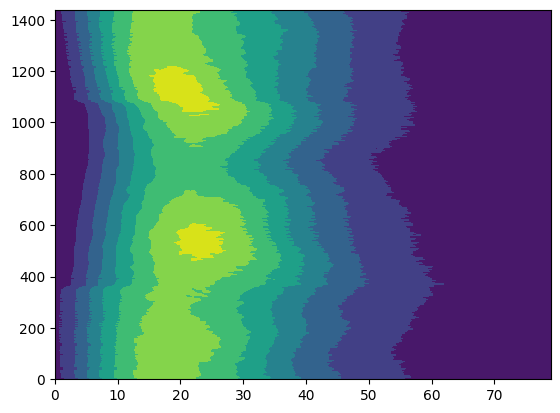

In [62]:
# Testing if the orientation of spliced peaks was correclt

profiles_360 = np.concatenate( ( 
    
    np.flip(V_degrees[:,:V_degrees.shape[1]//2], axis = 1),
    H_degrees[:,H_degrees.shape[1]//2:],
    V_degrees[:,V_degrees.shape[1]//2:],
    np.flip(H_degrees[:,:H_degrees.shape[1]//2], axis = 1),            
    
    ), axis = 0)

plt.contourf(profiles_360)

Text(0.5, 0.98, 'Axes Rotated 30 degrees')

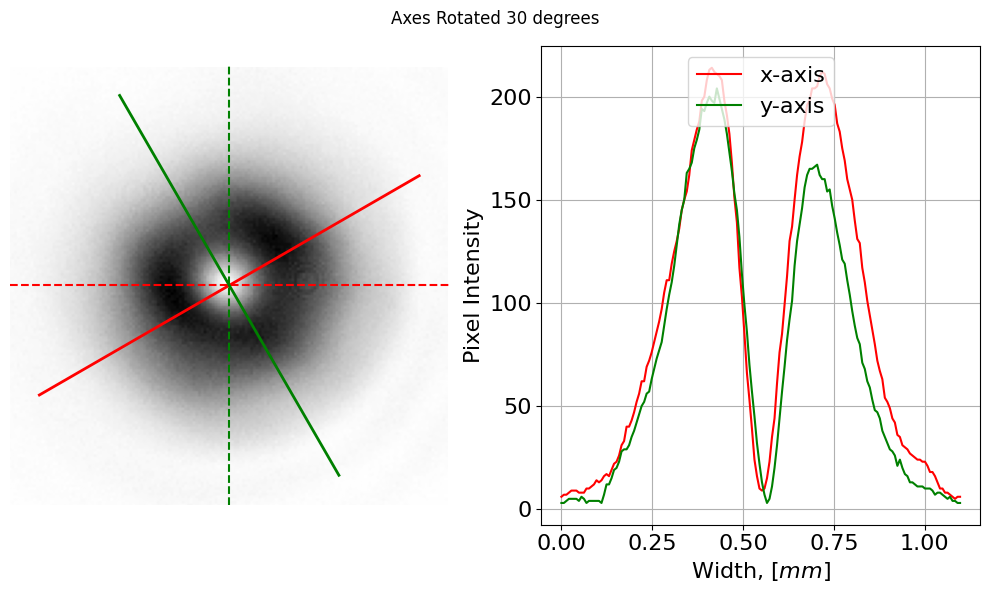

In [63]:
#%% [INITIALIZED PICTURE & INTENSITIES, TEST WITH DEGREES TO SEE AXIS CHANGE ANGLE]

degree = 30
deg_to_rad = (np.pi/180)*degree

h_coords = ([h//2 - radius*sin(deg_to_rad), w//2 - radius*cos(deg_to_rad)] , [h//2 + radius*sin(deg_to_rad), w//2 + radius*cos(deg_to_rad)])
v_coords = ([h//2 - radius*cos(deg_to_rad) , w//2 + radius*sin(deg_to_rad)] , [h//2 + radius*cos(deg_to_rad), w//2 - radius*sin(deg_to_rad)])

#%% {REASONING}
# Note that to rotate a line about a point is given by x = x0 +- radius*cos(theta), y = y0 +- radius*sin(theta)
# To ensure the axes stay orthogonal to each other, the derivatives are taken and done so for the vertical line

profile_h = profile_line(image,h_coords[0],h_coords[1], mode = 'constant')  # let the values outside be redundant data which can be cut off
profile_v = profile_line(image,v_coords[0],v_coords[1], mode = 'constant')
# save into a 2D matrix, given the pixels \times degree dimensions

# plot the figures
fig_img, ax = plt.subplots(1,2, figsize=(10, 6))
fig_img.set_tight_layout(True)
ax[0].imshow(image, cmap='binary')
ax[0].axhline(y = h//2, ls = '--', c = 'r')
ax[0].axvline(x = w//2, ls = '--', c = 'g')
ax[0].plot([h_coords[0][1],h_coords[1][1]],[h_coords[0][0],h_coords[1][0]],'r-',lw=2)
ax[0].plot([v_coords[0][1],v_coords[1][1]],[v_coords[0][0],v_coords[1][0]],'g-',lw=2)
ax[0].set_xlim([0,w])
ax[0].set_ylim([0,h])
ax[0].set_axis_off()
#%% [HORIZONTAL & VERTICAL INTENSITY PROFILES]

ax[1].plot(x*FLIR_s,profile_h[:D], 'r-', label = 'x-axis')
ax[1].plot(y*FLIR_s, profile_v[:D], 'g-', label = 'y-axis')

ax[1].set_xlabel("Width, [$mm$]", fontsize = axis_fontsize)
ax[1].set_ylabel("Pixel Intensity", fontsize = axis_fontsize)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = axis_fontsize)
ax[1].legend(fontsize = axis_fontsize, loc = 'upper center')
ax[1].grid(True)

fig_img.suptitle(f'Axes Rotated {degree} degrees')

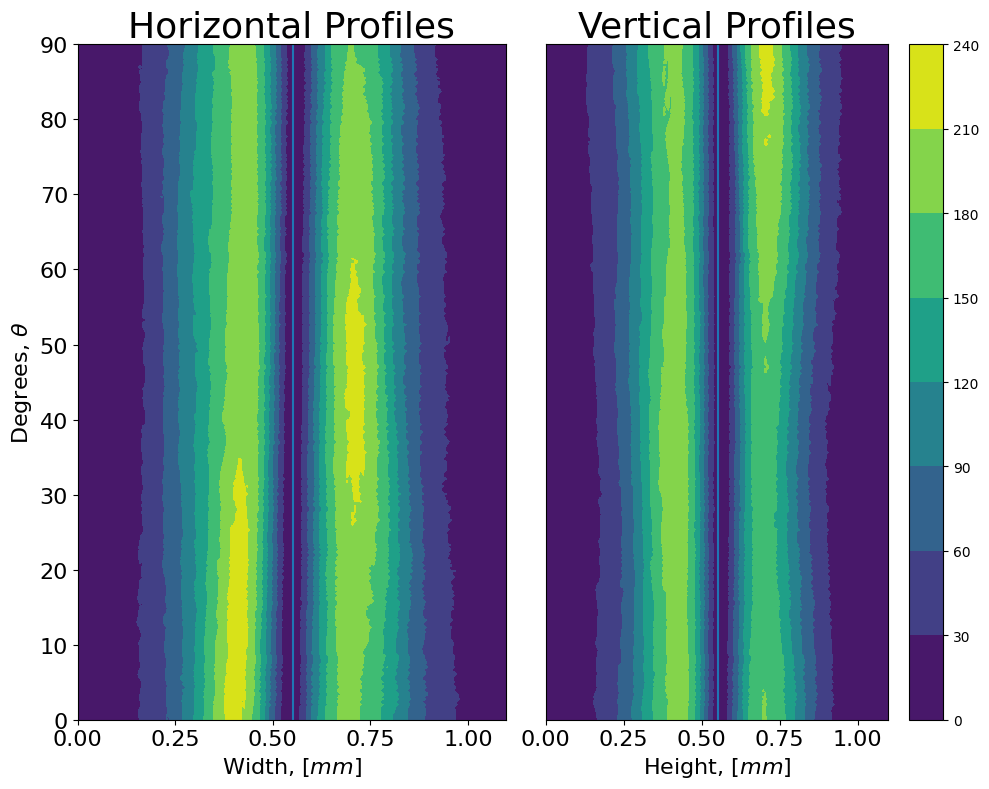

In [64]:
#%% [VISUALISATION OF INTENSITY PROFILES ALONG ANGLES FOR BOTH HORIZONTAL & VERTICAL AXES]
fig_contour, (axh, axv) = plt.subplots(1,2,figsize=(10,8))
fig_contour.set_tight_layout(True)

axh.contourf(np.arange(D)*FLIR_s,degrees*(180/np.pi),H_degrees)
axh.axvline(np.arange(D)[H_degrees.shape[1]//2]*FLIR_s)         # null point
axh.set_title("Horizontal Profiles", fontsize = title_fontsize)
axh.set_xlabel("Width, [$mm$]", fontsize = axis_fontsize)
axh.set_ylabel("Degrees, $\\theta$", fontsize = axis_fontsize)
axh.set_xticks(np.arange(D*FLIR_s, step=0.25))                   # same x-axis tick frequency
axh.tick_params(which = 'major', labelsize = axis_fontsize)

c = axv.contourf(np.arange(D)*FLIR_s,degrees*(180/np.pi),V_degrees)
axv.axvline(np.arange(D)[V_degrees.shape[1]//2]*FLIR_s)         # null point
axv.set_title("Vertical Profiles", fontsize = title_fontsize)
axv.set_xlabel("Height, [$mm$]", fontsize = axis_fontsize)
axv.set_xticks(np.arange(D*FLIR_s, step=0.25)) 
axv.set_yticks([])
axv.tick_params(which = 'major', labelsize = axis_fontsize)
fig_contour.colorbar(c,ax=axv)

Text(0.5, 0.98, '$E_{xt} = 10\\log_{\\frac{\\mu}{pix_{min}}}=$22.97 dB')

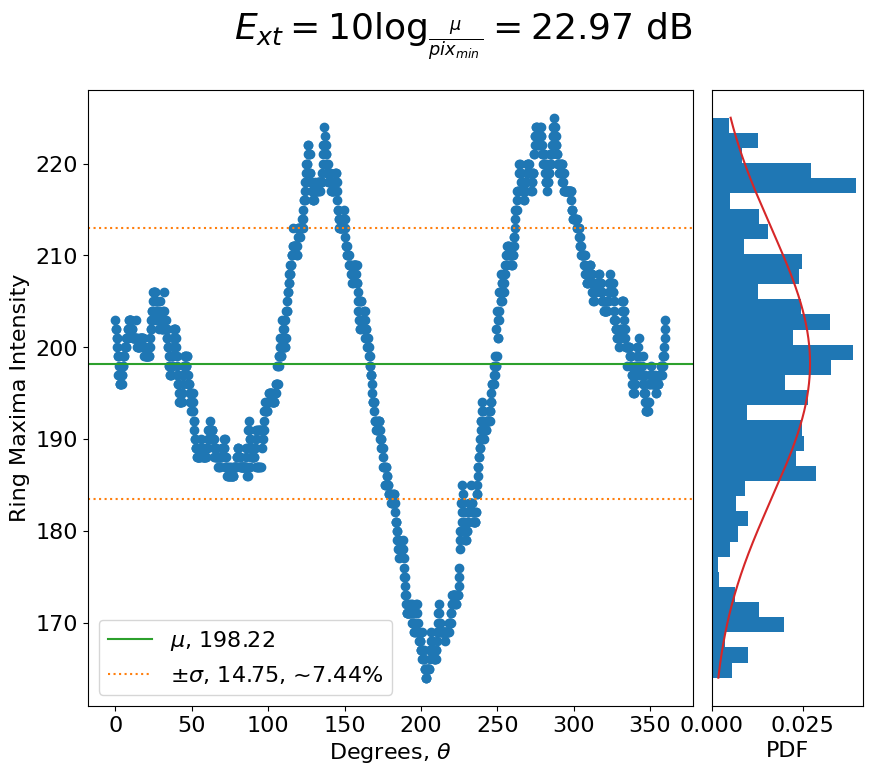

In [65]:
#%% [PLOT THE MAXIMAS IN SCATTER PLOT WITH HISTOGRAM] 

degrees = np.linspace(0,360,profiles_360.shape[0]) # for 360 degrees, all maximas obtained

fig_hist = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(1,2,width_ratios=(4,1),wspace=0.05)  # setup gridspec axes
axs = fig_hist.add_subplot(gs[0])                           # scatterplot
axh = fig_hist.add_subplot(gs[1], sharey=axs)               # histogram along y-axis
fig_hist.set_tight_layout(True)

axs.scatter(degrees, maximas_d, ls = '-')
axs.axhline(mean, c = 'tab:green', ls= '-', label = f'$\mu$, {mean:.2f}')
axs.axhline(mean + std, c = 'tab:orange', ls = ':', label = f'$\pm \sigma$, {std:.2f}, ~{100*std/mean:.2f}%')
axs.axhline(mean - std, c = 'tab:orange', ls = ':')
axs.set_xlabel('Degrees, $\\theta$', fontsize = axis_fontsize)
axs.set_ylabel('Ring Maxima Intensity', fontsize = axis_fontsize)
# axs.set_title('Maximum Intensity of Ring along Diameter', fontsize = title_fontsize)
axs.tick_params(axis = 'both', which = 'major', labelsize = axis_fontsize)
axs.legend(fontsize = axis_fontsize)

# histogram on side of the scatterplot
axh.hist(maximas_d, bins = int(sqrt(len(maximas_d))), range=(np.min(maximas_d), np.max(maximas_d)),
        density=True, orientation = 'horizontal', color = 'tab:blue')
x = np.arange(np.min(maximas_d), np.max(maximas_d), 0.001)
Gauss = lambda x: stats.norm.pdf(x, mean, std)
axh.plot(Gauss(x), x, c = 'tab:red', lw = '1.5')
axh.set_xlabel('PDF', fontsize = axis_fontsize)
axh.tick_params(axis = 'both', which = 'major', labelsize = axis_fontsize)
axh.yaxis.set_visible(False)

# add to title of graph
fig_hist.suptitle('$E_{xt} = 10\\log_{\\frac{\\mu}{pix_{min}}}=$' f'{10*np.log10((ext_ratio)):.2f} dB',fontsize = title_fontsize)